In [20]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats

In [21]:
data = pd.read_csv("train.csv")

# Checking the data

In [22]:
data.head()

encounter_id country  patient_id             race  gender      age weight  \
0        533253     USA       70110        Caucasian  Female  [70-80)      ?   
1        426224     USA    29775006  AfricanAmerican    Male  [50-60)      ?   
2        634063     USA    80729253        Caucasian  Female  [60-70)      ?   
3        890610     USA     2919042  AfricanAmerican    Male  [60-70)      ?   
4        654194     USA    84871971        Caucasian  Female  [70-80)      ?   

  payer_code  outpatient_visits_in_previous_year  \
0          ?                                   0   
1          ?                                   0   
2          ?                                   0   
3         MC                                   0   
4         HM                                   1   

   emergency_visits_in_previous_year  ...  secondary_diagnosis  \
0                                  0  ...                  276   
1                                  0  ...                  785   
2                                  0  ...                  135   
3                                  0  ...                  562   
4                                  0  ...                  599   

  additional_diagnosis number_diagnoses  glucose_test_result a1c_test_result  \
0                  466                8                  NaN             NaN   
1                  162                9                  NaN             NaN   
2                  250                6                  NaN             NaN   
3                  455                5                  NaN             NaN   
4                  428                9                  NaN             NaN   

  change_in_meds_during_hospitalization  prescribed_diabetes_meds  \
0                                    No                        No   
1                                    No                       Yes   
2                                    Ch                       Yes   
3                                    No                        No   
4                                    No                        No   

                   medication  readmitted_binary  readmitted_multiclass  
0                          []                 No               >30 days  
1                 ['insulin']                 No                     No  
2  ['glimepiride', 'insulin']                 No                     No  
3                          []                 No                     No  
4                          []                 No               >30 days  

[5 rows x 31 columns]

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   encounter_id                           71236 non-null  int64 
 1   country                                71236 non-null  object
 2   patient_id                             71236 non-null  int64 
 3   race                                   67682 non-null  object
 4   gender                                 71236 non-null  object
 5   age                                    67679 non-null  object
 6   weight                                 71236 non-null  object
 7   payer_code                             71236 non-null  object
 8   outpatient_visits_in_previous_year     71236 non-null  int64 
 9   emergency_visits_in_previous_year      71236 non-null  int64 
 10  inpatient_visits_in_previous_year      71236 non-null  int64 
 11  admission_type 

In [24]:
data.isna().sum()

encounter_id                                 0
country                                      0
patient_id                                   0
race                                      3554
gender                                       0
age                                       3557
weight                                       0
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3706
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_dia

In [25]:
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

country 0
race 1516
gender 0
age 0
weight 68990
payer_code 28201
admission_type 0
medical_specialty 34922
discharge_disposition 0
admission_source 0
primary_diagnosis 16
secondary_diagnosis 262
additional_diagnosis 1008
glucose_test_result 0
a1c_test_result 0
change_in_meds_during_hospitalization 0
prescribed_diabetes_meds 0
medication 0
readmitted_binary 0
readmitted_multiclass 0


In [26]:
#data["patient_id_count"] = data.groupby("patient_id")["patient_id"].transform("size")
#data["patient_count"] = data.groupby("patient_id").cumcount() + 1

In [27]:
# removing unusable variables
data.drop(["encounter_id", "patient_id", "country", "weight"],axis=1,inplace=True)

In [28]:
# separating categorical from numerical data
numerical = data[['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']]

non_numerical = data.drop(numerical.columns, axis=1)

In [29]:
numerical.corr().style.background_gradient(cmap='coolwarm')

# Feature Engineering

### Race

In [30]:
data["race"] = data["race"].replace("?", np.nan)

In [31]:
readmissions_by_race = data.groupby(['race', 'readmitted_binary'])['readmitted_binary'].count().unstack()

readmissions_by_race["Total"] = readmissions_by_race["No"] + readmissions_by_race["Yes"]
readmissions_by_race["No%"] = readmissions_by_race["No"] / readmissions_by_race["Total"]
readmissions_by_race["Yes%"] = readmissions_by_race["Yes"] / readmissions_by_race["Total"]
readmissions_by_race

readmitted_binary     No   Yes  Total       No%      Yes%
race                                                     
AfricanAmerican    11280  1413  12693  0.888679  0.111321
Asian                381    40    421  0.904988  0.095012
Caucasian          44931  5762  50693  0.886335  0.113665
Hispanic            1220   144   1364  0.894428  0.105572
Other                910    85    995  0.914573  0.085427

### Gender

In [32]:
data["gender"] = data["gender"].replace("Unknown/Invalid", np.nan)
data["gender"] = data["gender"].replace("Female", 1)
data["gender"] = data["gender"].replace("Male", 0)
data["gender"].value_counts()

1.0    38228
0.0    33005
Name: gender, dtype: int64

### Age

In [33]:
for i in range(0,10):
    data['age'] = data['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)

data["age"].value_counts()

8.0     17359
7.0     14908
9.0     11510
6.0     11423
5.0      6418
4.0      2536
10.0     1875
3.0      1071
2.0       474
1.0       105
Name: age, dtype: int64

In [34]:
readmissions_by_age = data.groupby(['age', 'readmitted_binary'])['readmitted_binary'].count().unstack()

readmissions_by_age["Total"] = readmissions_by_age["No"] + readmissions_by_age["Yes"]
readmissions_by_age["No%"] = readmissions_by_age["No"] / readmissions_by_age["Total"]
readmissions_by_age["Yes%"] = readmissions_by_age["Yes"] / readmissions_by_age["Total"]
readmissions_by_age

readmitted_binary     No   Yes  Total       No%      Yes%
age                                                      
1.0                  104     1    105  0.990476  0.009524
2.0                  445    29    474  0.938819  0.061181
3.0                  919   152   1071  0.858077  0.141923
4.0                 2260   276   2536  0.891167  0.108833
5.0                 5745   673   6418  0.895139  0.104861
6.0                10292  1131  11423  0.900989  0.099011
7.0                13286  1622  14908  0.891199  0.108801
8.0                15318  2041  17359  0.882424  0.117576
9.0                10096  1414  11510  0.877150  0.122850
10.0                1655   220   1875  0.882667  0.117333

### Payer_code

In [35]:
data["payer_code"].unique()

array(['?', 'MC', 'HM', 'UN', 'SP', 'SI', 'CM', 'DM', 'CP', 'MD', 'OG',
       'BC', 'PO', 'WC', 'OT', 'MP', 'CH', 'FR'], dtype=object)

In [36]:
data["payer_code"] = data["payer_code"].replace("?", "No_health_insurance")
data["payer_code"].value_counts()

No_health_insurance    28201
MC                     22683
HM                      4319
SP                      3541
BC                      3292
MD                      2484
CP                      1762
UN                      1733
CM                      1347
OG                       729
PO                       405
DM                       378
CH                       102
WC                        99
OT                        61
MP                        54
SI                        45
FR                         1
Name: payer_code, dtype: int64

In [37]:
#readmissions_by_payer_code = data.groupby(['payer_code', 'readmitted_binary'])['readmitted_binary'].count().unstack()

#readmissions_by_payer_code["Total"] = readmissions_by_payer_code["No"] + readmissions_by_payer_code["Yes"]
#readmissions_by_payer_code["No%"] = readmissions_by_payer_code["No"] / readmissions_by_payer_code["Total"]
#readmissions_by_payer_code["Yes%"] = readmissions_by_payer_code["Yes"] / readmissions_by_payer_code["Total"]
#readmissions_by_payer_code

### medical specialty

In [38]:
data["medical_specialty"].value_counts()

?                                34922
InternalMedicine                 10292
Emergency/Trauma                  5319
Family/GeneralPractice            5217
Cardiology                        3716
                                 ...  
Speech                               1
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Neurophysiology                      1
Name: medical_specialty, Length: 69, dtype: int64

In [45]:
data.drop("medical_specialty",axis=1,inplace=True)

### visits_in_previous_year

In [46]:
data['visits_in_previous_year'] = data['outpatient_visits_in_previous_year'] + data['emergency_visits_in_previous_year'] + data['inpatient_visits_in_previous_year']
data.drop(["outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year"],axis=1,inplace=True)

### admission_type

In [47]:
cat = data[~data['admission_type'].isin(['Emergency', 'Elective', 'Urgent'])]["admission_type"]
data['admission_type'] = data['admission_type'].replace(cat.unique(), np.nan)

In [48]:
data['admission_type'].unique()

array(['Emergency', nan, 'Elective', 'Urgent'], dtype=object)

### average_pulse_bpm

In [659]:
data["average_pulse_bpm"].value_counts()

63     951
89     950
109    948
99     946
134    943
      ... 
84     844
80     835
71     832
97     817
127    808
Name: average_pulse_bpm, Length: 80, dtype: int64

### discharge_disposition

In [660]:
data["discharge_disposition"].value_counts()

Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Expired                                                                                                       1135
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                                                   

In [40]:
def care_after_discharge_conversion(discharge_disposition):
    snf={"Discharged/transferred to SNF",
        "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare."}
    home={"Discharged/transferred to home with home health service",
        "Discharged/transferred to home under care of Home IV provider",
        "Discharged to home"}
    rehab={"Discharged/transferred to another rehab fac including rehab units of a hospital ."}
    short={"Discharged/transferred to another short term hospital",
        "Discharged/transferred to another type of inpatient care institution",
        "Discharged/transferred/referred to this institution for outpatient services",
        "Discharged/transferred/referred another institution for outpatient services",
        "Still patient or expected to return for outpatient services"}
    icf={"Discharged/transferred to ICF"}
    hospice={"Hospice / medical facility","Hospice / home",
        "Expired at home. Medicaid only, hospice.",
        "Discharged/transferred to a federal health care facility."}
    long={"Discharged/transferred to a long term care hospital.",
        "Discharged/transferred within this institution to Medicare approved swing bed",
        "Admitted as an inpatient to this hospital",
        "Neonate discharged to another hospital for neonatal aftercare"}
    psychiatry={"Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital"}
    left={"Left AMA"}
    if discharge_disposition in snf:
        return "snf"
    if discharge_disposition in home:
        return "home"
    if discharge_disposition in rehab:
        return "rehab"
    if discharge_disposition in short:
        return "short"
    if discharge_disposition in icf:
        return "icf"
    if discharge_disposition in hospice:
        return "hospice"
    if discharge_disposition in long:
        return "long"
    if discharge_disposition in psychiatry:
        return "psychiatry"
    if discharge_disposition in left:
        return "left"
    return "other"

In [41]:
data["discharge_disposition"]=data["discharge_disposition"].\
    map(care_after_discharge_conversion).astype("category")
for cat in ["snf","home","rehab","short","icf","hospice","long","psychiatry","left"]:
    data["discharge_("+cat+")"]=(data["discharge_disposition"]==cat).astype(int).astype(object)
data.drop("discharge_disposition",axis=1,inplace=True)

In [661]:
#categories = data[~data['discharge_disposition'].isin(['Discharged to home'])]["discharge_disposition"]
#data['discharge_disposition'] = data['discharge_disposition'].replace(categories.unique(), "Not discharged home")
#data['discharge_disposition'] = data['discharge_disposition'].replace("Not discharged home", 0)
#data['discharge_disposition'] = data['discharge_disposition'].replace("Discharged to home", 1)

#data['discharge_disposition'].value_counts()

1    42256
0    28980
Name: discharge_disposition, dtype: int64

### admission_source

In [49]:
data["admission_source"].value_counts()

 Emergency Room                                               40319
 Physician Referral                                           20678
Transfer from a hospital                                       2230
 Transfer from another health care facility                    1562
Clinic Referral                                                 779
 Transfer from a Skilled Nursing Facility (SNF)                 595
HMO Referral                                                    129
 Not Mapped                                                     107
 Not Available                                                   88
 Court/Law Enforcement                                           11
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth                                                 1
Normal Delivery                                 

In [50]:
data['admission_source'] = data['admission_source'].replace(" Not Mapped", np.nan)
data['admission_source'] = data['admission_source'].replace(" Not Available", np.nan)
categories1 = data[~data['admission_source'].isin([' Emergency Room', " Physician Referral", np.nan])]["admission_source"]
data['admission_source'] = data['admission_source'].replace(categories1.unique(), "Other")
data["admission_source"].unique()

array([' Emergency Room', 'Other', nan, ' Physician Referral'],
      dtype=object)

### length_of_stay_in_hospital

In [664]:
readmissions_by_payer_code = data.groupby(['length_of_stay_in_hospital', 'readmitted_binary'])['readmitted_binary'].count().unstack()

readmissions_by_payer_code["Total"] = readmissions_by_payer_code["No"] + readmissions_by_payer_code["Yes"]
readmissions_by_payer_code["No%"] = readmissions_by_payer_code["No"] / readmissions_by_payer_code["Total"]
readmissions_by_payer_code["Yes%"] = readmissions_by_payer_code["Yes"] / readmissions_by_payer_code["Total"]
readmissions_by_payer_code

readmitted_binary              No   Yes  Total       No%      Yes%
length_of_stay_in_hospital                                        
1                            9168   842  10010  0.915884  0.084116
2                           10922  1197  12119  0.901229  0.098771
3                           11088  1346  12434  0.891748  0.108252
4                            8517  1139   9656  0.882042  0.117958
5                            6133   834   6967  0.880293  0.119707
6                            4602   635   5237  0.878747  0.121253
7                            3605   549   4154  0.867838  0.132162
8                            2565   438   3003  0.854146  0.145854
9                            1826   279   2105  0.867458  0.132542
10                           1409   228   1637  0.860721  0.139279
11                           1182   140   1322  0.894100  0.105900
12                            882   128   1010  0.873267  0.126733
13                            767    92    859  0.892899  0.107101
14                            620   103    723  0.857538  0.142462

### number_lab_tests

<AxesSubplot:>

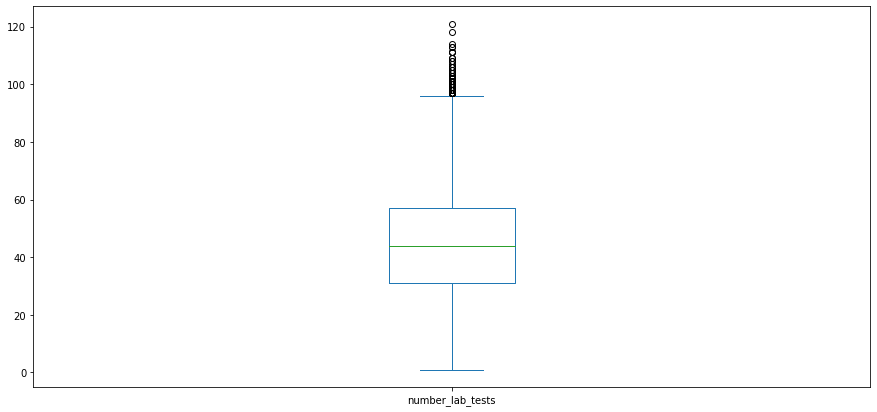

In [665]:
data["number_lab_tests"].plot.box(figsize = (15,7))

### non_lab_procedures

In [666]:
data["non_lab_procedures"].plot.box(figsize = (15,7))

<AxesSubplot:>

### number of medications

<AxesSubplot:>

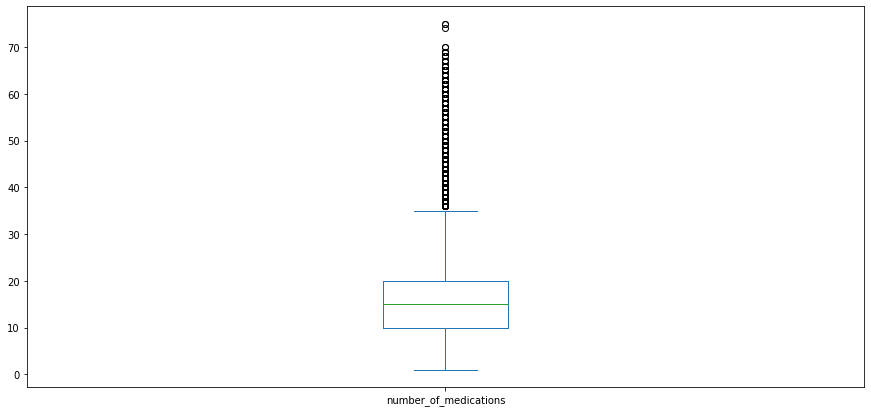

In [667]:
data["number_of_medications"].plot.box(figsize = (15,7))

### diagnosis

In [51]:
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

race 0
payer_code 0
admission_type 0
admission_source 0
primary_diagnosis 16
secondary_diagnosis 262
additional_diagnosis 1008
glucose_test_result 0
a1c_test_result 0
change_in_meds_during_hospitalization 0
prescribed_diabetes_meds 0
medication 0
readmitted_binary 0
readmitted_multiclass 0
discharge_(snf) 0
discharge_(home) 0
discharge_(rehab) 0
discharge_(short) 0
discharge_(icf) 0
discharge_(hospice) 0
discharge_(long) 0
discharge_(psychiatry) 0
discharge_(left) 0


In [52]:
def icd9_conversion(code):
    if code=="?" or code[0]=="M": return "?"
    if code[0]=="V": return "V"
    if code[0]=="E": return "E"
    if "." in code: return "B"
    try :
        code=int(code)
        if 1<=code<140: return "I&P"
        if 140<=code<240: return "NEO"
        if 240<=code<280: return "ENM&I"
        if 280<=code<290: return "B"
        if 290<=code<320: return "M"
        if 320<=code<390: return "N"
        if 390<=code<460: return "C"
        if 460<=code<520: return "R"
        if 520<=code<580: return "D"
        if 580<=code<630: return "G"
        if 630<=code<680: return "PC&P"
        if 680<=code<710: return "S"
        if 710<=code<740: return "M&C"
        if 740<=code<760: return "Cong"
        if 760<=code<780: return "PP"
        if 780<=code<800: return "SS&Ill"
        if 800<=code<1000: return "I&P"
    except ValueError:
        return "?"
    return "?"

In [53]:
for kind in ["primary_diagnosis","secondary_diagnosis","additional_diagnosis"]:
    data[kind]=data[kind].map(icd9_conversion).astype("category")

In [54]:
#data.drop(data.loc[data["primary_diagnosis"] == "?"].index, inplace = True)
data.drop(["secondary_diagnosis", "additional_diagnosis"],axis=1,inplace=True)

In [55]:
data['primary_diagnosis'] = data['primary_diagnosis'].replace("?", np.nan)

### Number of diagnosis

<AxesSubplot:>

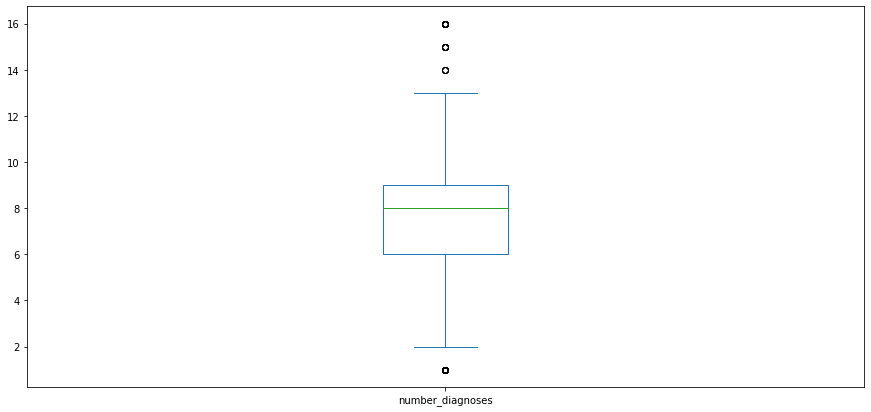

In [673]:
data["number_diagnoses"].plot.box(figsize = (15,7))

### glucose_test_result

In [58]:
data['glucose_test_result'] = data['glucose_test_result'].fillna('not measured')
data["glucose_test_result"].value_counts()

not measured    67548
Norm             1806
>200             1055
>300              827
Name: glucose_test_result, dtype: int64

### a1c_test_result

In [59]:
data['a1c_test_result'] = data['a1c_test_result'].fillna('not measured')
data['a1c_test_result'].value_counts()

not measured    59320
>8               5705
Norm             3503
>7               2708
Name: a1c_test_result, dtype: int64

### change_in_meds_during_hospitalization

In [60]:
data['change_in_meds_during_hospitalization'] = data['change_in_meds_during_hospitalization'].replace("Ch",1)
data['change_in_meds_during_hospitalization'] = data['change_in_meds_during_hospitalization'].replace("No",0)
data["change_in_meds_during_hospitalization"].value_counts()

0    38326
1    32910
Name: change_in_meds_during_hospitalization, dtype: int64

### prescribed_diabetes_meds

In [61]:
data['prescribed_diabetes_meds'] = data['prescribed_diabetes_meds'].replace("Yes",1)
data['prescribed_diabetes_meds'] = data['prescribed_diabetes_meds'].replace("No",0)
data["prescribed_diabetes_meds"].value_counts()

1    54890
0    16346
Name: prescribed_diabetes_meds, dtype: int64

### medication

In [62]:
import re
unique_medications=set()
for meds in data["medication"]:
    for compound_med in (re.search(r'(?<=\[)(.*?)(?=\])',meds)[0]).split(sep=','):
        if compound_med!="":
            compound_med=compound_med.strip()
            for med in compound_med.split(sep='-'):
                unique_medications.add(med.strip("'"))
for med in unique_medications:
    data[med]=data["medication"].map(lambda meds: med in meds).astype("int64")
data.drop("medication",axis=1,inplace=True)

In [63]:
data

race  gender  age           payer_code admission_type  \
0            Caucasian     1.0  8.0  No_health_insurance      Emergency   
1      AfricanAmerican     0.0  6.0  No_health_insurance      Emergency   
2            Caucasian     1.0  7.0  No_health_insurance            NaN   
3      AfricanAmerican     0.0  7.0                   MC      Emergency   
4            Caucasian     1.0  8.0                   HM       Elective   
...                ...     ...  ...                  ...            ...   
71231  AfricanAmerican     1.0  9.0                   MC       Elective   
71232  AfricanAmerican     1.0  8.0  No_health_insurance         Urgent   
71233        Caucasian     1.0  7.0  No_health_insurance            NaN   
71234        Caucasian     0.0  7.0                   BC      Emergency   
71235        Caucasian     0.0  8.0                   BC         Urgent   

       average_pulse_bpm     admission_source  length_of_stay_in_hospital  \
0                    127       Emergency Room                           2   
1                    128                Other                          14   
2                     94                  NaN                           6   
3                     81                Other                           6   
4                    126   Physician Referral                           6   
...                  ...                  ...                         ...   
71231                 90   Physician Referral                           7   
71232                 98   Physician Referral                           9   
71233                137                  NaN                           5   
71234                123       Emergency Room                           2   
71235                 62       Emergency Room                           5   

       number_lab_tests  non_lab_procedures  ...  nateglinide insulin  \
0                    48                   0  ...            0       0   
1                    71                   0  ...            0       1   
2                    60                   1  ...            0       1   
3                    48                   2  ...            0       0   
4                    47                   1  ...            0       0   
...                 ...                 ...  ...          ...     ...   
71231                51                   1  ...            0       1   
71232                20                   0  ...            0       0   
71233                25                   0  ...            0       1   
71234                34                   1  ...            0       1   
71235                42                   2  ...            0       1   

       glyburide acetohexamide tolazamide  tolbutamide  rosiglitazone  \
0              0             0          0            0              0   
1              0             0          0            0              0   
2              0             0          0            0              0   
3              0             0          0            0              0   
4              0             0          0            0              0   
...          ...           ...        ...          ...            ...   
71231          1             0          0            0              0   
71232          1             0          0            0              0   
71233          1             0          0            0              0   
71234          1             0          0            0              0   
71235          0             0          0            0              0   

      miglitol acarbose glipizide  
0            0        0         0  
1            0        0         0  
2            0        0         0  
3            0        0         0  
4            0        0         0  
...        ...      ...       ...  
71231        0        0         0  
71232        0        0         0  
71233        0        0         0  
71234        0        0         0  
71235        0        0         0  

[7123

In [64]:
data.columns.values.tolist()

['race',
 'gender',
 'age',
 'payer_code',
 'admission_type',
 'average_pulse_bpm',
 'admission_source',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'primary_diagnosis',
 'number_diagnoses',
 'glucose_test_result',
 'a1c_test_result',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'readmitted_binary',
 'readmitted_multiclass',
 'discharge_(snf)',
 'discharge_(home)',
 'discharge_(rehab)',
 'discharge_(short)',
 'discharge_(icf)',
 'discharge_(hospice)',
 'discharge_(long)',
 'discharge_(psychiatry)',
 'discharge_(left)',
 'visits_in_previous_year',
 'metformin',
 'repaglinide',
 'pioglitazone',
 'glimepiride',
 'chlorpropamide',
 'troglitazone',
 'nateglinide',
 'insulin',
 'glyburide',
 'acetohexamide',
 'tolazamide',
 'tolbutamide',
 'rosiglitazone',
 'miglitol',
 'acarbose',
 'glipizide']

### Removing Outliers

In [65]:
# get list of only numeric features
numeric = data[['visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']]
numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   visits_in_previous_year     71236 non-null  int64
 1   average_pulse_bpm           71236 non-null  int64
 2   length_of_stay_in_hospital  71236 non-null  int64
 3   number_lab_tests            71236 non-null  int64
 4   non_lab_procedures          71236 non-null  int64
 5   number_of_medications       71236 non-null  int64
 6   number_diagnoses            71236 non-null  int64
dtypes: int64(7)
memory usage: 3.8 MB


In [66]:
data.isna().sum()

race                                     5070
gender                                      3
age                                      3557
payer_code                                  0
admission_type                           7259
average_pulse_bpm                           0
admission_source                         4913
length_of_stay_in_hospital                  0
number_lab_tests                            0
non_lab_procedures                          0
number_of_medications                       0
primary_diagnosis                          16
number_diagnoses                            0
glucose_test_result                         0
a1c_test_result                             0
change_in_meds_during_hospitalization       0
prescribed_diabetes_meds                    0
readmitted_binary                           0
readmitted_multiclass                       0
discharge_(snf)                             0
discharge_(home)                            0
discharge_(rehab)                 

In [67]:
skewness = numeric.skew()

print(skewness)

visits_in_previous_year       5.266438
average_pulse_bpm            -0.008550
length_of_stay_in_hospital    1.135477
number_lab_tests             -0.236649
non_lab_procedures            1.315643
number_of_medications         1.330452
number_diagnoses             -0.878218
dtype: float64


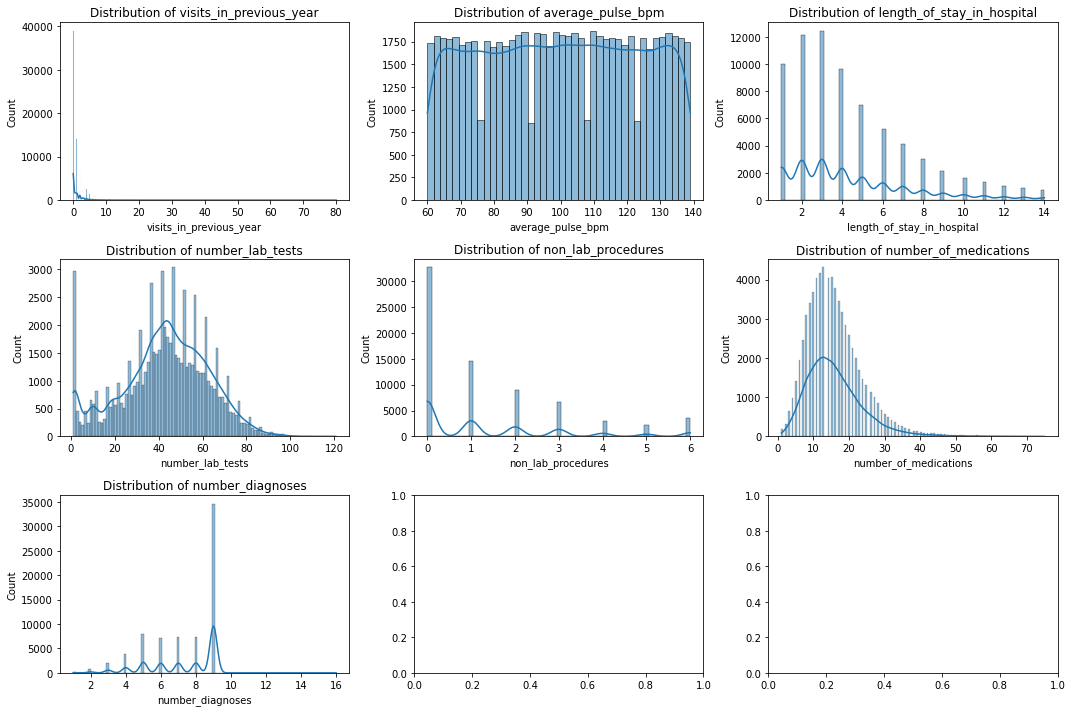

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with numeric variables
numeric_variables = data[['visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']]

# Set up the figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot histograms for each numeric variable
for i, column in enumerate(numeric_variables.columns):
    sns.histplot(data[column], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [69]:
for column in numeric.columns:
    skewness = data[column].skew()
    if skewness > 0.5 or skewness < -0.5:   
        data[column] = np.log1p(data[column])

In [70]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'data' is your DataFrame with numeric variables
numeric_variables = data[['visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(numeric_variables)

# Create a DataFrame from the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=numeric_variables.columns)

data.reset_index(drop=True, inplace=True)

# Drop the original columns from data and concatenate scaled_df
data = pd.concat([data.drop(numeric.columns.tolist(), axis=1), normalized_df], axis=1)

data[numeric.columns.tolist()]

visits_in_previous_year  average_pulse_bpm  length_of_stay_in_hospital  \
0                     0.250000           0.848101                    0.201233   
1                     0.000000           0.860759                    1.000000   
2                     0.157732           0.430380                    0.621749   
3                     0.157732           0.265823                    0.621749   
4                     0.157732           0.835443                    0.621749   
...                        ...                ...                         ...   
71231                 0.157732           0.379747                    0.688020   
71232                 0.000000           0.481013                    0.798767   
71233                 0.366243           0.974684                    0.545243   
71234                 0.250000           0.797468                    0.201233   
71235                 0.157732           0.025316                    0.545243   

       number_lab_tests  non_lab_procedures  number_of_medications  \
0              0.391667            0.000000               0.646411   
1              0.583333            0.000000               0.705124   
2              0.491667            0.356207               0.671420   
3              0.391667            0.564575               0.442447   
4              0.383333            0.356207               0.571654   
...                 ...                 ...                    ...   
71231          0.416667            0.356207               0.618897   
71232          0.158333            0.000000               0.442447   
71233          0.200000            0.000000               0.694342   
71234          0.275000            0.356207               0.534945   
71235          0.341667            0.564575               0.442447   

       number_diagnoses  
0              0.702818  
1              0.752051  
2              0.585385  
3              0.513354  
4              0.752051  
...                 ...  
71231          0.752051  
71232          0.585385  
71233          0.752051  
71234          0.513354  
71235          0.702818  

[71236 rows x 7 columns]

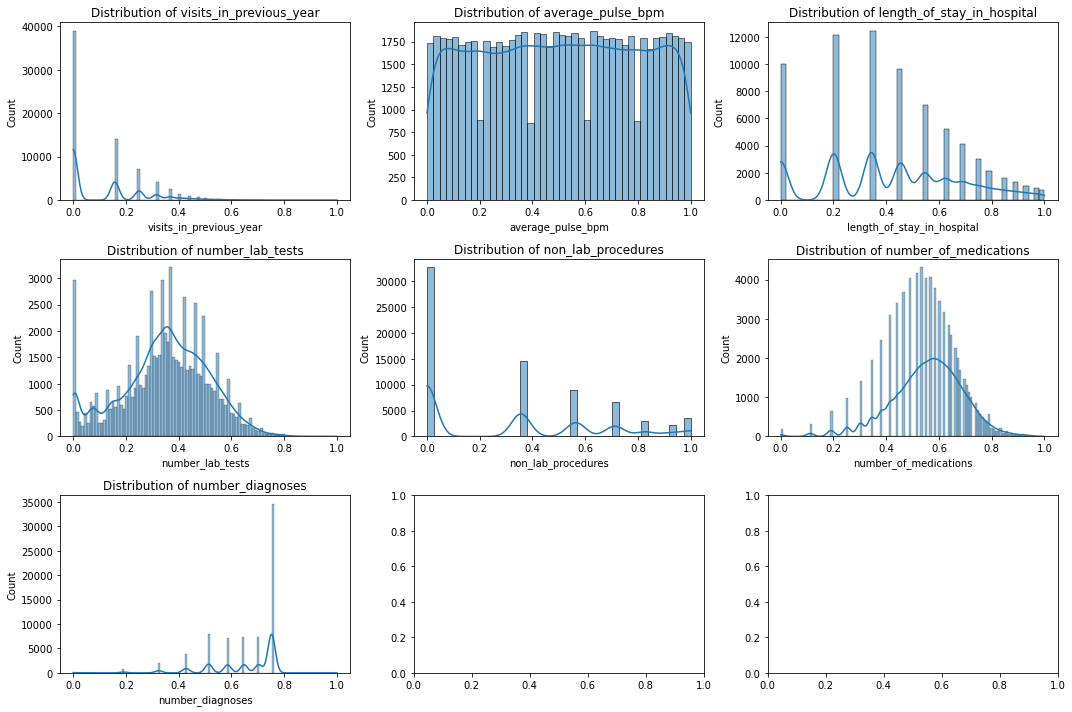

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with numeric variables
numeric_variables = data[['visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']]

# Set up the figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot histograms for each numeric variable
for i, column in enumerate(numeric_variables.columns):
    sns.histplot(data[column], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}')

# Adjust layout
plt.tight_layout()
plt.show()


In [72]:
numeric_variables.skew()

visits_in_previous_year       1.113410
average_pulse_bpm            -0.008550
length_of_stay_in_hospital    0.107359
number_lab_tests             -0.236649
non_lab_procedures            0.518838
number_of_medications        -0.480771
number_diagnoses             -1.504172
dtype: float64

In [689]:
#for col in numeric_variables.columns.values.tolist():
 #   Q1 = data[col].quantile(0.25)
  #  Q3 = data[col].quantile(0.75)
   # IQR = Q3 - Q1

    # Define a lower and upper bound to identify outliers
    #lower_bound = Q1 - 1.5 * IQR
    #upper_bound = Q3 + 1.5 * IQR

    # Create a new DataFrame with outliers removed
    #data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   race                                   66166 non-null  object  
 1   gender                                 71233 non-null  float64 
 2   age                                    67679 non-null  float64 
 3   payer_code                             71236 non-null  object  
 4   admission_type                         63977 non-null  object  
 5   average_pulse_bpm                      71236 non-null  int64   
 6   discharge_disposition                  71236 non-null  int64   
 7   admission_source                       66323 non-null  object  
 8   length_of_stay_in_hospital             71236 non-null  float64 
 9   number_lab_tests                       71236 non-null  int64   
 10  non_lab_procedures                     71236 non-null  flo

In [73]:
cols_impute = ["race", "gender", "age", "admission_type", "admission_source", "primary_diagnosis"]

for col in cols_impute:
    most_frequent = data[col].mode()[0]
    data[col] = data[col].fillna(most_frequent)

data.isna().sum()

race                                     0
gender                                   0
age                                      0
payer_code                               0
admission_type                           0
admission_source                         0
primary_diagnosis                        0
glucose_test_result                      0
a1c_test_result                          0
change_in_meds_during_hospitalization    0
prescribed_diabetes_meds                 0
readmitted_binary                        0
readmitted_multiclass                    0
discharge_(snf)                          0
discharge_(home)                         0
discharge_(rehab)                        0
discharge_(short)                        0
discharge_(icf)                          0
discharge_(hospice)                      0
discharge_(long)                         0
discharge_(psychiatry)                   0
discharge_(left)                         0
metformin                                0
repaglinide

In [691]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   race                                   71236 non-null  object  
 1   gender                                 71236 non-null  float64 
 2   age                                    71236 non-null  float64 
 3   payer_code                             71236 non-null  object  
 4   admission_type                         71236 non-null  object  
 5   average_pulse_bpm                      71236 non-null  int64   
 6   discharge_disposition                  71236 non-null  int64   
 7   admission_source                       71236 non-null  object  
 8   length_of_stay_in_hospital             71236 non-null  float64 
 9   number_lab_tests                       71236 non-null  int64   
 10  non_lab_procedures                     71236 non-null  flo

In [74]:
y = data['readmitted_binary'].replace(['No', 'Yes'], [0, 1])
y2 = data['readmitted_binary'].replace(['No', 'Yes'], [0, 1])

In [75]:
X = data.drop(["readmitted_binary","readmitted_multiclass"], axis=1)
X = pd.get_dummies(X, drop_first = True)

print(X.columns.values.tolist())

['gender', 'age', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'metformin', 'repaglinide', 'pioglitazone', 'glimepiride', 'chlorpropamide', 'troglitazone', 'nateglinide', 'insulin', 'glyburide', 'acetohexamide', 'tolazamide', 'tolbutamide', 'rosiglitazone', 'miglitol', 'acarbose', 'glipizide', 'visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'payer_code_CH', 'payer_code_CM', 'payer_code_CP', 'payer_code_DM', 'payer_code_FR', 'payer_code_HM', 'payer_code_MC', 'payer_code_MD', 'payer_code_MP', 'payer_code_No_health_insurance', 'payer_code_OG', 'payer_code_OT', 'payer_code_PO', 'payer_code_SI', 'payer_code_SP', 'payer_code_UN', 'payer_code_WC', 'admission_type_Emergency', 'admission_type_Urgent', 'admission_source_ Physician Referral', 'admission_source_Other', 'primary_diagnosis_C', 'prim

### Modeling

In [77]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(class_weight={0:0.14,
                                                     1:0.86},
                                       learning_rate=0.05,
                                       random_state=7,
                                       max_iter= 60,
                                       max_leaf_nodes= 40)

In [78]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight={0:0.12,
                                          1:0.88},
                             n_estimators= 100,
                             max_depth= 100,
                             min_samples_split= 0.02,
                            random_state = 46)

In [79]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LassoCV, RidgeCV

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

def avg_score_ns(model):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    
    #encoding too
    
    for train_index, test_index in skf.split(X,y):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
       
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        predict_train = model.predict(X_train)
        predict_val = model.predict(X_val)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = f1_score(y_train, predict_train)
        # check the mean accuracy for the test
        value_test = f1_score(y_val, predict_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

def show_results_ns(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    #scale = scale
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score_ns(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df

In [80]:
df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['hgb','rf'])
show_results_ns(df, hgb, rf)

Time        Train          Test
hgb  4.367+/-0.22  0.307+/-0.0  0.273+/-0.01
rf    9.782+/-0.2  0.287+/-0.0   0.27+/-0.01

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [82]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [84]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 4, random_state=0)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print(pd.DataFrame(cm,
             index=["Miss", "Hit"],
             columns=['pred_Miss', 'pred_Hit']))

print(classification_report(y_test, y_pred))

      pred_Miss  pred_Hit
Miss       9260      9716
Hit         678      1717
              precision    recall  f1-score   support

           0       0.93      0.49      0.64     18976
           1       0.15      0.72      0.25      2395

    accuracy                           0.51     21371
   macro avg       0.54      0.60      0.44     21371
weighted avg       0.84      0.51      0.60     21371



In [459]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components = 30)  # Choose the number of components based on the explained variance you want to retain
#X_train_pca = pca.fit_transform(X_resampled)
#X_test_pca = pca.transform(X_test)

In [85]:
# calculate accuracy
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier(n_estimators = 150, random_state=42)
model.fit(X_resampled, y_resampled)
# make class predictions for the testing set
y_pred_class = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_class)

print(pd.DataFrame(cm,
             index=["Miss", "Hit"],
             columns=['pred_Miss', 'pred_Hit']))

print(classification_report(y_test, y_pred_class))

      pred_Miss  pred_Hit
Miss      11712      7264
Hit         954      1441
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     18976
           1       0.17      0.60      0.26      2395

    accuracy                           0.62     21371
   macro avg       0.55      0.61      0.50     21371
weighted avg       0.84      0.62      0.69     21371



In [86]:
feature_names = X_train.columns
feature_imports = model.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest')
plt.show()

                       Feature  Importance
52         primary_diagnosis_C    0.017220
0                       gender    0.021559
26            number_diagnoses    0.044212
24          non_lab_procedures    0.044872
1                          age    0.053448
20     visits_in_previous_year    0.064640
22  length_of_stay_in_hospital    0.065138
25       number_of_medications    0.087182
23            number_lab_tests    0.098028
21           average_pulse_bpm    0.099827


In [87]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()

logit.fit(X_resampled, y_resampled)

y_pred = logit.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print(pd.DataFrame(cm,
             index=["Miss", "Hit"],
             columns=['pred_Miss', 'pred_Hit']))

print(classification_report(y_test, y_pred))

      pred_Miss  pred_Hit
Miss      12222      6754
Hit         986      1409
              precision    recall  f1-score   support

           0       0.93      0.64      0.76     18976
           1       0.17      0.59      0.27      2395

    accuracy                           0.64     21371
   macro avg       0.55      0.62      0.51     21371
weighted avg       0.84      0.64      0.70     21371



In [463]:
from sklearn.svm import SVC

#model = SVC()

#model.fit(X_resampled, y_resampled)

#y_pred = model.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
#print(metrics.confusion_matrix(y_test, y_pred))
#print(metrics.f1_score(y_test, y_pred, average=None))

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_resampled, y_resampled)

y_pred = gb_model.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average=None))

0.6192503860371531
[[11766  7210]
 [  927  1468]]
[0.74306104 0.26514946]


In [507]:
df = pd.read_csv("test.csv")

In [508]:
df

encounter_id country  patient_id             race  gender      age  \
0            499502     USA   103232799        Caucasian    Male  [80-90)   
1            447319     USA    93395304        Caucasian    Male  [20-30)   
2            309126     USA     6281586  AfricanAmerican    Male  [30-40)   
3            181183     USA    67381308        Caucasian    Male  [50-60)   
4            359339     USA    71670204        Caucasian    Male  [60-70)   
...             ...     ...         ...              ...     ...      ...   
30525        451150     USA    85707450        Caucasian    Male  [70-80)   
30526        549298     USA      328887        Caucasian    Male  [60-70)   
30527        327586     USA    21915459        Caucasian  Female  [80-90)   
30528        351214     USA    17823546        Caucasian    Male      NaN   
30529        914270     USA    42043239        Caucasian  Female  [60-70)   

      weight payer_code  outpatient_visits_in_previous_year  \
0          ?         HM                                   0   
1          ?         HM                                   0   
2          ?          ?                                   0   
3          ?         BC                                   0   
4          ?          ?                                   0   
...      ...        ...                                 ...   
30525      ?         HM                                   0   
30526      ?          ?                                   0   
30527      ?          ?                                   0   
30528      ?         MC                                   0   
30529      ?         MD                                   0   

       emergency_visits_in_previous_year  ...  number_of_medications  \
0                                      0  ...                     14   
1                                      0  ...                      7   
2                                      0  ...                     12   
3                                      0  ...                     16   
4                                      0  ...                     10   
...                                  ...  ...                    ...   
30525                                  0  ...                     11   
30526                                  0  ...                     19   
30527                                  0  ...                     22   
30528                                  0  ...                     21   
30529                                  0  ...                     11   

      primary_diagnosis secondary_diagnosis  additional_diagnosis  \
0                   491                 414                   250   
1                250.13                  70                   794   
2                   786               250.6                   536   
3                   820                 873                  E884   
4                   599                 427                   414   
...                 ...                 ...                   ...   
30525               584                 276                   276   
30526               428              250.83                   276   
30527               996                 403                   250   
30528               153                 780                   285   
30529               486                   ?                   428   

      number_diagnoses glucose_test_result  a1c_test_result  \
0                    6                 NaN              NaN   
1                    7                >300              NaN   
2                    6                 NaN              NaN   
3                    9                 NaN              NaN   
4                    9                 NaN              NaN   
...                ...                 ...              ...   
30525                9                 NaN              NaN   
30526                9                 NaN              NaN   
30527                6                 NaN              NaN   
3

In [509]:
df.drop(["encounter_id", "patient_id", "country", "weight", "medical_specialty", "payer_code"],axis=1,inplace=True)

In [510]:
df["gender"] = df["gender"].replace("Female", 1)
df["gender"] = df["gender"].replace("Male", 0)



In [511]:
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)

df["age"].value_counts()

8.0     7350
7.0     6493
6.0     4947
9.0     4857
5.0     2777
4.0     1059
10.0     782
3.0      500
2.0      182
1.0       52
Name: age, dtype: int64

In [512]:
df['visits_in_previous_year'] = df['outpatient_visits_in_previous_year'] + df['emergency_visits_in_previous_year'] + df['inpatient_visits_in_previous_year']
df.drop(["outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year"],axis=1,inplace=True)

In [513]:
df = df[df['admission_type'].isin(['Emergency', 'Elective', 'Urgent'])]
df = df[~df['admission_source'].isin([' Not Mapped',' Not Available'])]
categories1 = df[~df['admission_source'].isin([' Emergency Room', " Physician Referral"])]["admission_source"]
df['admission_source'] = df['admission_source'].replace(categories1.unique(), "Other")
df["admission_source"].value_counts()

 Emergency Room        16574
 Physician Referral     8136
Other                   2561
Name: admission_source, dtype: int64

In [514]:
categories = df[~df['discharge_disposition'].isin(['Discharged to home'])]["discharge_disposition"]
df['discharge_disposition'] = df['discharge_disposition'].replace(categories.unique(), "Not discharged home")
df['discharge_disposition'] = df['discharge_disposition'].replace("Not discharged home", 0)
df['discharge_disposition'] = df['discharge_disposition'].replace("Discharged to home", 1)

df['discharge_disposition'].value_counts()

1    16352
0    10919
Name: discharge_disposition, dtype: int64

In [515]:
for kind in ["primary_diagnosis","secondary_diagnosis","additional_diagnosis"]:
    df[kind]=df[kind].map(icd9_conversion).astype("category")

In [516]:
df.drop(df.loc[df["primary_diagnosis"] == "?"].index, inplace = True)
df.drop(["secondary_diagnosis", "additional_diagnosis"],axis=1,inplace=True)

In [517]:
df['glucose_test_result'] = df['glucose_test_result'].fillna('not measured')
df['a1c_test_result'] = df['a1c_test_result'].fillna('not measured')
df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].replace("Ch",1)
df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].replace("No",0)
df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].replace("Yes",1)
df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].replace("No",0)

In [518]:
import re
unique_medications=set()
for meds in df["medication"]:
    for compound_med in (re.search(r'(?<=\[)(.*?)(?=\])',meds)[0]).split(sep=','):
        if compound_med!="":
            compound_med=compound_med.strip()
            for med in compound_med.split(sep='-'):
                unique_medications.add(med.strip("'"))
for med in unique_medications:
    df["meds_("+med+")?"]=df["medication"].map(lambda meds: med in meds)
df.drop("medication",axis=1,inplace=True)

In [519]:
numeric = df[['visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']]

for column in numeric.columns:
    skewness = df[column].skew()
    if skewness > 0.5 or skewness < -0.5:   
        df[column] = np.log1p(df[column])

In [520]:
# Assuming 'data' is your DataFrame with numeric variables
numeric_variables = df[['visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(numeric_variables)

# Create a DataFrame from the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=numeric_variables.columns)

df.reset_index(drop=True, inplace=True)

# Drop the original columns from data and concatenate scaled_df
df = pd.concat([df.drop(numeric.columns.tolist(), axis=1), normalized_df], axis=1)


In [521]:
X1 = df
X1 = pd.get_dummies(X1)

In [527]:
X.columns.tolist()

['gender',
 'age',
 'discharge_disposition',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'meds_(repaglinide)?',
 'meds_(glimepiride)?',
 'meds_(rosiglitazone)?',
 'meds_(insulin)?',
 'meds_(chlorpropamide)?',
 'meds_(glyburide)?',
 'meds_(metformin)?',
 'meds_(miglitol)?',
 'meds_(tolbutamide)?',
 'meds_(acarbose)?',
 'meds_(pioglitazone)?',
 'meds_(tolazamide)?',
 'meds_(glipizide)?',
 'meds_(nateglinide)?',
 'visits_in_previous_year',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'number_diagnoses',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'admission_type_Emergency',
 'admission_type_Urgent',
 'admission_source_ Physician Referral',
 'admission_source_Other',
 'primary_diagnosis_B',
 'primary_diagnosis_C',
 'primary_diagnosis_Cong',
 'primary_diagnosis_D',
 'primary_diagnosis_ENM&I',
 'primary_diagnosis_G',
 'primary_diagnosis_I&P',
 'primary_diagnosis_

In [538]:
common_columns = list(set(X) & set(X1))
X1_filtered = X1[common_columns]
X1_filtered = X1_filtered[X.columns.tolist()]
X1_filtered.columns.tolist()


gender  age  discharge_disposition  \
0           0  9.0                      1   
1           0  3.0                      1   
2           0  4.0                      1   
3           0  7.0                      1   
4           1  4.0                      1   
...       ...  ...                    ...   
27260       0  6.0                      0   
27261       0  8.0                      0   
27262       0  7.0                      1   
27263       1  9.0                      0   
27265       1  7.0                      1   

       change_in_meds_during_hospitalization  prescribed_diabetes_meds  \
0                                          0                         1   
1                                          0                         0   
2                                          0                         1   
3                                          0                         1   
4                                          0                         0   
...                                      ...                       ...   
27260                                      0                         0   
27261                                      0                         0   
27262                                      0                         1   
27263                                      0                         1   
27265                                      0                         1   

       meds_(repaglinide)?  meds_(glimepiride)?  meds_(rosiglitazone)?  \
0                    False                False                  False   
1                    False                False                  False   
2                    False                False                  False   
3                    False                False                  False   
4                    False                False                  False   
...                    ...                  ...                    ...   
27260                False                False                  False   
27261                False                False                  False   
27262                False                False                  False   
27263                False                False                  False   
27265                False                False                  False   

       meds_(insulin)?  meds_(chlorpropamide)?  ...  primary_diagnosis_R  \
0                False                   False  ...                    1   
1                False                   False  ...                    0   
2                 True                   False  ...                    0   
3                False                   False  ...                    0   
4                False                   False  ...                    0   
...                ...                     ...  ...                  ...   
27260            False                   False  ...                    0   
27261            False                   False  ...                    0   
27262             True                   False  ...                    0   
27263             True                   False  ...                    0   
27265            False                   False  ...                    1   

       primary_diagnosis_S  primary_diagnosis_SS&Ill  primary_diagnosis_V  \
0                        0                         0                    0   
1                        0                         0                    0   
2                        0                         1                    0   
3                        0                         0                    0   
4                        0                         1                    0   
...                    ...                       ...                  ...   
27260                    1                         0                    0   
27261                    0                         0                    0   
27262                    0                         0                    0   
27263

In [540]:
X1_filtered = X1_filtered.dropna()


In [541]:
y_pred = model.predict(X1_filtered)


In [545]:
pd.Series(y_pred).value_counts()

No     14866
Yes    11025
dtype: int64